<a href="https://colab.research.google.com/github/ErnestoFCh/Simulacion-II/blob/main/Simpy_Cine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Entorno de Simulación (`Environment`)

El `Environment` es el núcleo de la simulación en `SimPy`. Este objeto controla el tiempo y coordina los eventos en la simulación.
Creacion de entorno:


```
 env= simpy.Environment()
```
Con `env.run(until=TIEMPO_SIMULACION)`, haces avanzar la simulación hasta el tiempo especificado.


```
env.run(until= 20) #20 unidades de tiempo
```




## 2. Procesos
Un proceso en `SimPy` representa una entidad que experimenta cambios a lo largo del tiempo. Los procesos en `SimPy` se crean usando funciones de Python que incluyen al menos un `yield`.

Definir un proceso permite que las funciones "pausen" su ejecución y esperen a que termine un evento determinado usando `yield`.

Ejemplo:


```
def proceso_cliente(env):
    print(f"Cliente llega en el minuto {env.now}")
    yield env.timeout(5)  # Simula una pausa de 5 minutos
    print(f"Cliente termina en el minuto {env.now}")
env.process(proceso_cliente(env))
```



## 3. Eventos (`Timeout` y `Process`)
Un evento es una ocurrencia que sucede en un tiempo específico.
Los eventos más comunes en `SimPy` son:

`timeout`: Representa un tiempo de espera antes de que ocurra el siguiente evento. En el ejemplo anterior:


```
yield env.timeout(5)  # Pausa el proceso durante 5 unidades de tiempo (en este caso minutos)
```

`process`: Inicia otro proceso o subproceso dentro de un proceso.


```
cliente = env.process(proceso_cliente(env)) #inicia el proceso: proceso_cliente

```

## 4. Recursos (`Resource`)

Un recurso representa algo que puede ser utilizado por los procesos y está limitado en cantidad, como cajeros, máquinas o empleados.
En `SimPy`, puedes crear recursos usando `simpy.Resource(env, capacity=n)`, donde `capacity` define cuántos procesos pueden usar el recurso al mismo tiempo.

Ejemplo:



```
cajero = simpy.Resource(env, capacity=1)  # Solo un cliente puede ser atendido a la vez

with cajero.request() as solicitud:
    yield solicitud  # Espera hasta que el recurso esté disponible
    yield env.timeout(3)  # Simula un tiempo de servicio de 3 minutos
```
Nota:  `with cajero.request() as solicitud`: Crea una solicitud para usar el recurso cajero. Aquí el cliente solicita al cajero para poder ser atendido.



## 5. Generadores y Distribuciones Aleatorias
`SimPy` usa generadores para manejar la llegada de entidades y la duración de eventos en tiempos aleatorios, usando distribuciones como la exponencial (por ejemplo, para modelar intervalos entre llegadas de clientes) o la normal.

Ejemplo:
Generaremos un tiempo de llegada entre clientes:


```
tiempo_llegada = random.expovariate(1.0 / INTERVALO_LLEGADA) #definimos un tiempo de llegada
yield env.timeout(tiempo_llegada) #se detiene en unidades de tiempo establecidos por: "tiempo_llegada"
```




## Cola en dulceria de Cinepolis.
Simularemos un cola de Cinepolis un domingo con función estelar con los siguientes datos, estos datos son en base a la experiencia.

- Tiempo en caja: entre 2 y 5 minutos
- Tiempo de llegada entre clientes: 2 minutos
- Numero de cajas: 1
- El tiempo de proyeccion entre funciones es de 19 min.

Además el siguiente código es una adaptacion del codigo presentado en clase, esto para fines didacticos y para comprender mejor el uso de la libreria `simpy`. Se haran comentarios del codigo.

Autor del código: `Vixuz144.`

Adaptado por: Ernesto Franco.

In [1]:
import pkg_resources  #Revisamos si la libreria simpy esta instalada o no para ahorra tiempo de ejecucion
package_name = 'simpy'
installed_packages = [pkg.key for pkg in pkg_resources.working_set]

if package_name not in installed_packages:
    !pip install simpy

In [2]:
import matplotlib.pyplot as plt  #Importamos las librerias que se usaran
import numpy as np
from random import random, seed
import pandas as pd
import simpy

In [3]:
def cine(env, boleto, nc, texto=True): #funcion cine que corresponde a la llegada de clientes al cine
    global  ll, cifras, dur_venta, t_esp, fin_sim, LTLL, LC, LS

    for i in range(nc):
        #Llegada del cliente
        r = random()
        tll = -np.log(r)/ll
        yield env.timeout(tll)  #tiempo de espera de tll unidades de tiempo
        LTLL.append(env.now)    #se guardan las unidades de tiempo
        if texto:
          print(f'----Ha llegado el cliente número {i} en el minuto {round(env.now, cifras)}----')

        env.process(transaccion(env, boleto, i, texto)) #iniciamos el proceso transaccion

Notas:

Variable globales: Las variables `ll`, `cifras`, `dur_venta`, `t_esp`, `fin_sim`, `LTLL`, `LC` y `LS` son declaradas como globales. Quiere decir que cualquier cambio que se haga a estas variables dentro de la función `cine` afectará a las variables globales con los mismos nombres fuera de la función.

In [4]:
def transaccion(env, boleto, num, texto=True): #funcion transaccion que corresponde a la venta de productos al cliente
    global tc_min, tc_max, cifras, dur_venta, LC, LS
    a, b = tc_min, tc_max
    #Solicitud de venta
    with boleto.request() as sol:
        yield sol

        #Inicia la venta

        #Se genera el tiempo de venta
        r = random()
        tc = a + (b-a)*r
        dur_venta += tc
        LC.append(tc)
        if texto:
          print(f'****Inicia la venta del cliente {num} en el minuto {round(env.now, cifras)}****')
        #Se suma el tiempo a la line ade tiempo actual
        yield env.timeout(tc)

        #Muestra un mensaje al término de venta
        LS.append(env.now)
        if texto:
          print(f'xxxTermina la venta del cliente {num} en el minuto {round(env.now, cifras)}xxx')
        return tc

In [5]:
global tc_min, tc_max, ll, no_cajas, cifras
semilla = 13
seed(semilla)

no_cajas = 1  #definimos el numero de cajas
tc_min = 2    #tiempo minimo de atencion en caja
tc_max = 5    #tiempo maximo de atencion en caja
ll = 1/2      #Tasa media de llegadas
clientes = 3  #numero de clientes de estudio
cifras = 2    #cifras decimales

In [6]:
global t_esp, dur_venta, fin_sim, LTLL, LC, LS  #estas variables ayudan a recopilar informacion de la simulacion
t_esp = 0
dur_venta = 0
fin_sim = 0

LTLL, LC, LS = [], [], []

In [7]:
ent = simpy.Environment() #Creamos las variables de entorno y recursos.
boleto = simpy.Resource(ent, capacity=no_cajas)

In [8]:
ent.process(cine(ent, boleto, clientes)) #Creamos la simulación a travéz del comando process.

<Process(cine) object at 0x7d9c23d6fb80>

In [9]:
ent.run() #Ejecuta la simulación durante 19 minutos

----Ha llegado el cliente número 0 en el minuto 2.7----
****Inicia la venta del cliente 0 en el minuto 2.7****
----Ha llegado el cliente número 1 en el minuto 3.46----
----Ha llegado el cliente número 2 en el minuto 3.78----
xxxTermina la venta del cliente 0 en el minuto 6.75xxx
****Inicia la venta del cliente 1 en el minuto 6.75****
xxxTermina la venta del cliente 1 en el minuto 9.31xxx
****Inicia la venta del cliente 2 en el minuto 9.31****
xxxTermina la venta del cliente 2 en el minuto 12.0xxx


In [10]:
LTLL, LC, LS = np.array(LTLL), np.array(LC), np.array(LS)
t_esp = sum(LS - LTLL - LC)
fin_sim = ent.now

In [11]:
print(LTLL)   #presentamos los recuentos de la simulación así como sus resultados.
print(LC)
print(LS)
print(t_esp, dur_venta, fin_sim)

[2.70178886 3.45770862 3.78430906]
[4.05224575 2.55717252 2.69167583]
[ 6.75403462  9.31120714 12.00288297]
8.823224069012545 9.301094102565942 12.002882965113615


In [12]:
dato1 = f'Longitud promedio de la cola (fila): {round(t_esp/fin_sim, 2)} personas en cola'
print(dato1)

dato2=f'Tiempo de espera promedio: {round(t_esp/clientes,2)} minutos'
print(dato2)

print(f'Uso promedio de la instalación: {round(100 * dur_venta/fin_sim,2)}%')

Longitud promedio de la cola (fila): 0.74 personas en cola
Tiempo de espera promedio: 2.94 minutos
Uso promedio de la instalación: 77.49%


Generaremos el experimento para ver que sucede en el cine con el paso de los días. Esto quiere decir que no tomares en cuenta los datos anteriores, ahora seran los datos para un dia normal.Para lo cual usaremos la siguiente función.

- Tiempo en caja: entre 2 y 5 minutos
- Tiempo de llegada entre clientes: 5 minutos
- Numero de cajas: 1
- El tiempo de proyeccion entre funciones es de 19 min.

In [13]:
def exp(n): #definimos la funcion experimento, el cual se repite n-veces
  global tc_min, tc_max, ll, no_cajas, t_esp, dur_venta, fin_sim, LTLL, LC, LS

  no_cajas = 1
  tc_min = 2
  tc_max = 5
  ll = 1/5
  clientes = 3
  cifras = 2

  long_cola = []
  tiempo_esp = []
  uso = []
#Volvemos definir el Environment pero esta vez se repite n-veces
  for _ in range(n):
    t_esp = 0
    dur_venta = 0
    fin_sim = 0

    LTLL, LC, LS = [], [], []

    ent = simpy.Environment()
    boleto = simpy.Resource(ent, capacity=no_cajas)
    ent.process(cine(ent, boleto, clientes, texto=False))
    ent.run()
    LTLL, LC, LS = np.array(LTLL), np.array(LC), np.array(LS)
    t_esp = sum(LS - LTLL - LC)
    fin_sim = ent.now

    long_cola.append(t_esp/fin_sim)
    tiempo_esp.append(t_esp/clientes)
    uso.append(100 * dur_venta/fin_sim)

  return long_cola, tiempo_esp, uso

In [14]:
n = 500 #repetimos el Environment 500 veces
a, b, c = exp(n)

In [15]:
def graf_estado(l, titulo):
  g = []
  n = len(l)
  for i in range(n):
    g.append(np.mean(l[:i+1]))
  plt.plot(g, 'navy')
  m = np.mean(l)
  s = np.std(l, ddof=1)
  plt.hlines(m, 0, n, color='r', linestyles='dotted')
  plt.hlines(m + 1.96*np.std(l)/np.sqrt(n), 0, n, color='g', linestyles='dashed')
  plt.hlines(m - 1.96*np.std(l)/np.sqrt(n), 0, n, color='g', linestyles='dashed')
  plt.title(titulo)
  plt.xlabel('iteraciones')
  plt.show()
  return m

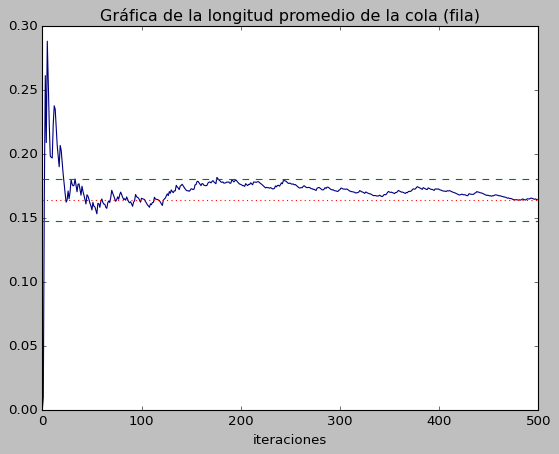

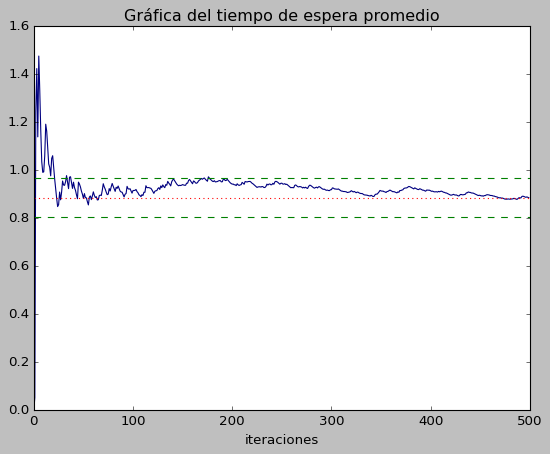

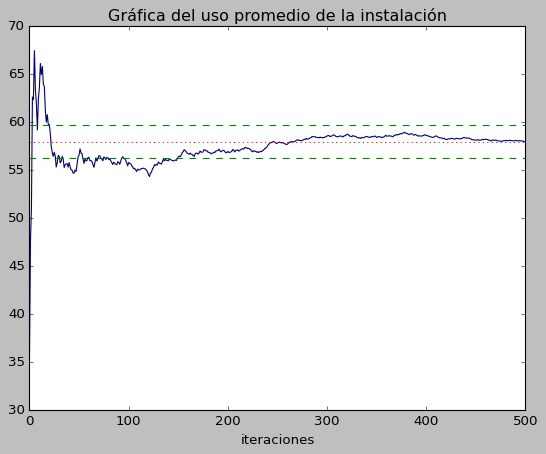

In [16]:
plt.style.use('classic')
m1=graf_estado(a, 'Gráfica de la longitud promedio de la cola (fila)')
m2=graf_estado(b, 'Gráfica del tiempo de espera promedio')
m3=graf_estado(c, 'Gráfica del uso promedio de la instalación')

In [17]:
print(f'La longitud promedio de la cola (fila) es de: {np.round(m1, cifras)} personas en cola')
print(f'El tiempo de espera promedio es de: {np.round(m2, cifras)} minutos')
print(f'Uso promedio de la instalación es de: {np.round(m3, cifras)}%')

La longitud promedio de la cola (fila) es de: 0.16 personas en cola
El tiempo de espera promedio es de: 0.88 minutos
Uso promedio de la instalación es de: 57.95%


Notemos que la diferencia entre la logitud de la cola y el promedio de minutos de espera a diferencia de un dia domingo es logica.

In [18]:
print("Datos para una funcion estelar en domingo:")
print(dato1)
print(dato2)

print("Datos promedios a traves de los dias:")
print(f'La longitud promedio de la cola (fila) es de: {np.round(m1, cifras)} personas en cola')
print(f'El tiempo de espera promedio es de: {np.round(m2, cifras)} minutos')

Datos para una funcion estelar en domingo:
Longitud promedio de la cola (fila): 0.74 personas en cola
Tiempo de espera promedio: 2.94 minutos
Datos promedios a traves de los dias:
La longitud promedio de la cola (fila) es de: 0.16 personas en cola
El tiempo de espera promedio es de: 0.88 minutos


Se espera que en una funcion estelar en domingo tenga mas personas en cola y el tiempo de espera sea mayor, a diferencia de un dia cualquiera, lo cual se confirma con la experiencia.


Ahora se generara un intervalo de confianza para cáda valor A TRAVES DEL TIEMPO.

In [19]:
def rep(n, nr):
  la, lb, lc = [], [], []
  for _ in range(nr):
    a, b, c = exp(n)
    la.append(np.mean(a))
    lb.append(np.mean(b))
    lc.append(np.mean(c))
  return la, lb, lc

In [20]:
n = 500 #tamaño de la muestra
nr = 100 #numero de experimentos
a, b, c = rep(n, nr)

In [21]:
from scipy.stats import t
ma, mb, mc = np.mean(a), np.mean(b), np.mean(c)
sa, sb, sc = np.std(a, ddof=1), np.std(b, ddof=1), np.std(c, ddof=1)
t_student = t.ppf(0.975, nr-1)
# print(t_student)
intervalo_a = (ma - t_student*sa/np.sqrt(nr), ma + t_student*sa/np.sqrt(nr))
intervalo_b = (mb - t_student*sb/np.sqrt(nr), mb + t_student*sb/np.sqrt(nr))
intervalo_c = (mc - t_student*sc/np.sqrt(nr), mc + t_student*sc/np.sqrt(nr))
dec = 5

In [22]:
print(f'El intervalo de confianza al 95% de la longitud promedio de la cola (fila): {np.round(intervalo_a, dec)} personas en cola')
print(f'El intervalo de confianza al 95% del tiempo de espera promedio: {np.round(intervalo_b, dec)} minutos')
print(f'El intervalo de confianza al 95% del uso promedio de la instalación: {np.round(intervalo_c, dec)}%')

El intervalo de confianza al 95% de la longitud promedio de la cola (fila): [0.1674  0.17051] personas en cola
El intervalo de confianza al 95% del tiempo de espera promedio: [0.88042 0.89528] minutos
El intervalo de confianza al 95% del uso promedio de la instalación: [58.6117  58.97764]%
